# Modeling

- Baseline - move the end of the EDA notebook to the start of this
- Preprocessing - need to try bag of words, Word to Vec, other tokenization schemes
    - pipelines!!
- Modeling
    - combine Ph3 evaluate and Ph4 score-tracker functions 
    - Focus on precision (you don't want false positives!!!)
    

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import regex as re
from wordcloud import WordCloud
import ast #converting column values to lists post-import from csv

from nltk import FreqDist
from nltk.corpus import stopwords


from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [8]:
X_numbers_df = pd.read_csv('data/X_numbers_only.csv', index_col=0)
X_numbers_df.head()


,num_ingredients,num_steps,num_char_description
0,6,4,301
1,13,10,138
2,9,1,57
3,14,6,392
4,8,4,164


In [9]:
y_numbers_df = pd.read_csv('data/y_numbers_only.csv', index_col=0)
type(y_numbers_df)

pandas.core.frame.DataFrame

In [11]:
y_numbers_df.head()

,target
0,0
1,0
2,0
3,1
4,0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_numbers_df, y_numbers_df, test_size = .3)

In [13]:
scalar = StandardScaler()

In [14]:
X_train_numbers_scaled = scalar.fit_transform(X_train, y_train)
X_train_numbers_scaled

array([[ 4.33934563, -0.16064771, -0.26144084],
       [ 0.14014313, -1.33412657, -0.69238251],
       [ 1.37520269,  0.5434396 , -0.21954373],
       ...,
       [-0.84790452, -0.86473502, -0.27341144],
       [ 0.38715504, -0.39534348, -0.08786712],
       [ 0.14014313,  0.77813537,  0.85182513]])

In [15]:
X_test_numbers_scaled = scalar.transform(X_test)
X_test_numbers_scaled

array([[-0.10686879,  0.30874383,  0.0438095 ],
       [-0.10686879, -0.39534348, -0.6445001 ],
       [ 0.14014313, -1.0994308 ,  0.47475117],
       ...,
       [-0.60089261, -0.39534348, -0.06991121],
       [-1.09491643, -0.16064771, -0.59661769],
       [-0.10686879,  1.24752691, -0.662456  ]])

In [16]:
sm = SMOTE()
X_train_num_sc_bal, y_train_num_sc_bal = sm.fit_resample(X_train_numbers_scaled, y_train)

In [17]:
len(X_train_num_sc_bal)

541352

In [18]:
len(y_train_num_sc_bal)

541352

In [19]:
X_test_num_sc_bal, y_test_num_sc_bal = sm.fit_resample(X_test_numbers_scaled, y_test)

In [20]:
y_test_num_sc_bal.value_counts()

target
1         116013
0         116013
dtype: int64

In [21]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, cv=5, grid_search=False):
    '''
Function takes in estimator, training data, test data, a Boolean value indicating if the estimator is a grid search, 
and the cross validation splitting strategy if the estimator is not a grid search, 
and returns the accuracy, precision, recall, f1, and the ROC-AUC scores for the model 
and a confusion matrix visualization.  From Phase 3 Project: https://github.com/Nindorph/TanzanianWaterWells/blob/main/Modeling_Final.ipynb

If ‘grid_search parameter is set to “True” then the function will not perform cross validation on the model. 
Based off of Lindsey Berlin’s evaluate function found at: 
https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb
------------------------------------------------------------------------------------------
Inputs: 
-Estimator - Estimator object  
-X_tr – X_train dataframe
-X_te – X_test dataframe
-Y_tr – y_train dataframe
-Y_te – y_test dataframe
-Cv – If cross_val  set to true this determines the cross-validation splitting strategy.  
        Takes in all value options for sklearn.model_selection_cross_val_score “cv” parameter:
        - None, to use the default 5-fold cross validation,
        - int, to specify the number of folds in a (Stratified)KFold,
        - CV splitter,
        - An iterable yielding (train, test) splits as arrays of indices
- grid_search – “ Boolean indicating whether a the estimator is a GridSearchCV object, 
        if set to “False” a cross validation will be performed with the number of iterations set by the “cv” parameter.  
        Default value is “False”.

Returns – nothing is returned 


    '''
    #If no grid search is being performed, go through evaluation steps as normal, including cross validation
    if grid_search == False:
        #Cross-Validate
        output = cross_validate(estimator, X_tr, y_tr, cv=cv,
                                scoring=['accuracy', 'precision','recall', 'f1', 'roc_auc'])
        #Printing out the mean of all of our evaluating metrics across the cross validation. 
        #Accuracy, precisionc recall, f1, and roc auc
        print('Results of Cross-Validation:\n')
        print(f'Average accuracy: {output["test_accuracy"].mean()}\
        +/- {output["test_accuracy"].std()}')
        print(f'Average precision: {output["test_precision"].mean()}\
        +/- {output["test_precision"].std()}')
        print(f'**Average recall: {output["test_recall"].mean()}\
        +/- {output["test_recall"].std()}')
        print(f'Average f1 score: {output["test_f1"].mean()}\
        +/- {output["test_f1"].std()}')
        print(f'Average roc_auc: {output["test_roc_auc"].mean()}\
        +/- {output["test_roc_auc"].std()}\n')
        print('+'*20)
    
        
        #Fitting the estimator to our X and y train data
        estimator.fit(X_tr, y_tr)
        #getting predictions for X train
        tr_preds = estimator.predict(X_tr)
        #getting predictions for X test
        te_preds = estimator.predict(X_te)
        
        #Creating a confusion matrix from our data with custom labels
        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')
        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')
        
        #Printing our final evaluating metrics across X train
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")
        print("<>"*10)
        #Printing our final evaluating metrics across X test
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"**Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")
    
    #If a grid search is being performed, do not perform a cross validate.
    else:
        #Fitting the estimator to our X and y train data
        estimator.fit(X_tr, y_tr)
        #getting predictions for X train
        tr_preds = estimator.predict(X_tr)
        #getting predictions for X test
        te_preds = estimator.predict(X_te)
        
        #Creating a confusion matrix from our data with custom labels
        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')
        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')
        
        #Printing our final evaluating metrics across X train 
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")
        print("<>"*10)
        
        #Printing our final evaluating metrics across X test
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")
        
        print('\nGrid Search Results (you animal):\n')
        return pd.DataFrame(estimator.cv_results_)

In [22]:
logreg = LogisticRegression()

C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

Results of Cross-Validation:

Average accuracy: 0.5573656311948996        +/- 0.0013369300572363106
Average precision: 0.549305867266036        +/- 0.0011794796609864685
**Average recall: 0.6391072761697332        +/- 0.0010823400109380465
Average f1 score: 0.5908135244105172        +/- 0.001109575375668234
Average roc_auc: 0.5744671406672129        +/- 0.0017850404340462901

++++++++++++++++++++


C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.5575041747328909
Train precision: 0.5494120709578291
**Train recall: 0.6393880506583517
Train f1 score: 0.5909950826389838
Train roc_auc: 0.5575041747328909

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.5601053330230232
Test precision: 0.5515441817832379
**Test recall: 0.6431520605449389
Test f1 score: 0.593835929883205
Test roc_auc: 0.5601053330230233


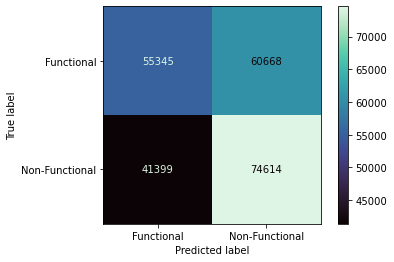

In [23]:
evaluate(logreg, X_train_num_sc_bal, X_test_num_sc_bal, y_train_num_sc_bal, y_test_num_sc_bal)

In [24]:
# numbers-only model performance is slightly above 50%, so room for the "real" model to be better

## Preprocessing

In [26]:
def return_to_list(df, column_names):
    ''' Takes in list of names of columns containing strings and the dataframe they sit in and returns converts each column's contents into a new
    column, called '<original column name>_list', now as lists. May only work on strings that look like lists.... 
    
    Inputs:
    df = dataframe with columns being converted to lists
    column_names = list of columns whose contents need to be transformed
    
    Returns: updated dataframe
    '''
    for col in column_names:
        col_name = col + '_list'
        df[col_name] = [ast.literal_eval(x) for x in df[col] ]
    
    return df

In [119]:
df = pd.read_csv('data/data_with_target_tokens.csv', index_col=0)

In [120]:
df.head()

,Unnamed: 0.1,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,...,tags_list,search_terms_list,num_ingredients,num_steps,num_char_description,cleaned_steps,clean_tweet,step_tokens,cleaned_description,description_tokens
0,0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...",...,"['time-to-make', 'course', 'main-ingredient', ...","['low-calorie', 'low-carb', 'diabetic', 'veget...",6,4,301,i a sauce pan bring water to a boil slowly add...,"['i a sauce pan, bring water to a boil; slowly...","['i', 'a', 'sauce', 'pan', 'bring', 'water', '...",we love grits this is another good way to serv...,"['we', 'love', 'grits', 'this', 'is', 'another..."
1,1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...",...,"['60-minutes-or-less', 'time-to-make', 'course...","['shrimp', 'dinner']",13,10,138,in a food processor pulse the onion red pepper...,"['in a food processor, pulse the onion, red pe...","['in', 'a', 'food', 'processor', 'pulse', 'the...",simple easy and very tasty for when you are in...,"['simple', 'easy', 'and', 'very', 'tasty', 'fo..."
2,3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...",...,"['weeknight', 'time-to-make', 'course', 'main-...","['italian', 'vegetarian', 'side']",9,1,57,put all ingredients in the crock pot and cook ...,['put all ingredients in the crock pot and coo...,"['put', 'all', 'ingredients', 'in', 'the', 'cr...",this is a good recipe for weight watchers it i...,"['this', 'is', 'a', 'good', 'recipe', 'for', '..."
3,4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",...,"['time-to-make', 'course', 'main-ingredient', ...",['dinner'],14,6,392,preheat oven to f cut beef into inch cubes com...,"['preheat oven to °f.', ""cut beef into inch cu...","['preheat', 'oven', 'to', 'f', 'cut', 'beef', ...",this is a fabulous stew that came from one of ...,"['this', 'is', 'a', 'fabulous', 'stew', 'that'..."
4,5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'preparation', 'des...",...,"['time-to-make', 'course', 'preparation', 'des...",['dessert'],8,4,164,preheat oven to f place almonds in single laye...,['preheat oven to °f place almonds in single l...,"['preheat', 'oven', 'to', 'f', 'place', 'almon...",this is one of our standard holiday gift recip...,"['this', 'is', 'one', 'of', 'our', 'standard',..."


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485306 entries, 0 to 485305
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Unnamed: 0.1              485306 non-null  int64 
 1   id                        485306 non-null  int64 
 2   name                      485306 non-null  object
 3   description               485306 non-null  object
 4   ingredients               485306 non-null  object
 5   ingredients_raw_str       485306 non-null  object
 6   serving_size              485306 non-null  object
 7   servings                  485306 non-null  int64 
 8   steps                     485306 non-null  object
 9   tags                      485306 non-null  object
 10  search_terms              485306 non-null  object
 11  target_tag                485306 non-null  bool  
 12  target_search_term        485306 non-null  bool  
 13  target                    485306 non-null  int64 
 14  ingr

In [122]:
df_strings = df[['description','steps','search_terms_list','tags_list', 'target']]

In [123]:
df_strings.head()

,description,steps,search_terms_list,tags_list,target
0,"We love grits, this is another good way to ser...","['I a sauce pan, bring water to a boil; slowly...","['low-calorie', 'low-carb', 'diabetic', 'veget...","['time-to-make', 'course', 'main-ingredient', ...",0
1,"Simple, easy and very tasty for when you are i...","['In a food processor, pulse the onion, red pe...","['shrimp', 'dinner']","['60-minutes-or-less', 'time-to-make', 'course...",0
2,This is a good recipe for weight watchers. It ...,['Put all ingredients in the crock pot and coo...,"['italian', 'vegetarian', 'side']","['weeknight', 'time-to-make', 'course', 'main-...",0
3,This is a fabulous stew that came from one of ...,"['Preheat oven to 350°F.', ""Cut beef into 1 in...",['dinner'],"['time-to-make', 'course', 'main-ingredient', ...",1
4,This is one of our standard holiday gift recip...,['Preheat oven to 375°F Place almonds in sing...,['dessert'],"['time-to-make', 'course', 'preparation', 'des...",0


In [124]:
def basic_cleaning(df, column):
    new_col = 'cleaned_' +column
    # convert to lowercase
    df[new_col] = df[column].apply(lambda x: x.lower())
    
    # remove punctuation and non-characters
    df[new_col] = df[new_col].apply(lambda x: re.sub(r'[^\w\s]','',x))
    df[new_col] = df[new_col].apply(lambda x: re.sub('[0-9\n]',' ',x))

    #strip whitespace
    df[new_col] = df[new_col].apply(lambda x: re.sub('[ ]{2,}',' ',x))
    
    return df

In [125]:
df_strings = basic_cleaning(df_strings, 'description')

<ipython-input-124-105abf01fa32>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[column].apply(lambda x: x.lower())
<ipython-input-124-105abf01fa32>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[new_col].apply(lambda x: re.sub(r'[^\w\s]','',x))
<ipython-input-124-105abf01fa32>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [126]:
df_strings = basic_cleaning(df_strings, 'steps')

<ipython-input-124-105abf01fa32>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[column].apply(lambda x: x.lower())
<ipython-input-124-105abf01fa32>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[new_col].apply(lambda x: re.sub(r'[^\w\s]','',x))
<ipython-input-124-105abf01fa32>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [132]:
df_strings['search_terms_list'] = df_strings['search_terms_list'].apply(lambda x: re.sub('[\'\'\[\],-]','',x))


<ipython-input-132-f851b9416c32>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strings['search_terms_list'] = df_strings['search_terms_list'].apply(lambda x: re.sub('[\'\'\[\],-]','',x))


In [134]:
df_strings['tags_list'] = df_strings['tags_list'].apply(lambda x: re.sub('[\'\'\[\],-]','',x))


<ipython-input-134-4f17ec630256>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strings['tags_list'] = df_strings['tags_list'].apply(lambda x: re.sub('[\'\'\[\],-]','',x))


In [117]:
df_strings = basic_cleaning(df_strings, 'tags_list')

<ipython-input-96-105abf01fa32>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[column].apply(lambda x: x.lower())
<ipython-input-96-105abf01fa32>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[new_col].apply(lambda x: re.sub(r'[^\w\s]','',x))
<ipython-input-96-105abf01fa32>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [135]:
df_strings.head()

,description,steps,search_terms_list,tags_list,target,cleaned_description,cleaned_steps
0,"We love grits, this is another good way to ser...","['I a sauce pan, bring water to a boil; slowly...",lowcalorie lowcarb diabetic vegetarian side,timetomake course mainingredient preparation o...,0,we love grits this is another good way to serv...,i a sauce pan bring water to a boil slowly add...
1,"Simple, easy and very tasty for when you are i...","['In a food processor, pulse the onion, red pe...",shrimp dinner,60minutesorless timetomake course mainingredie...,0,simple easy and very tasty for when you are in...,in a food processor pulse the onion red pepper...
2,This is a good recipe for weight watchers. It ...,['Put all ingredients in the crock pot and coo...,italian vegetarian side,weeknight timetomake course mainingredient pre...,0,this is a good recipe for weight watchers it i...,put all ingredients in the crock pot and cook ...
3,This is a fabulous stew that came from one of ...,"['Preheat oven to 350°F.', ""Cut beef into 1 in...",dinner,timetomake course mainingredient preparation m...,1,this is a fabulous stew that came from one of ...,preheat oven to f cut beef into inch cubes com...
4,This is one of our standard holiday gift recip...,['Preheat oven to 375°F Place almonds in sing...,dessert,timetomake course preparation desserts candy d...,0,this is one of our standard holiday gift recip...,preheat oven to f place almonds in single laye...


In [137]:
df_strings.drop(columns = ['description','steps'], inplace=True)
df_strings

C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,search_terms_list,tags_list,target,cleaned_description,cleaned_steps
0,lowcalorie lowcarb diabetic vegetarian side,timetomake course mainingredient preparation o...,0,we love grits this is another good way to serv...,i a sauce pan bring water to a boil slowly add...
1,shrimp dinner,60minutesorless timetomake course mainingredie...,0,simple easy and very tasty for when you are in...,in a food processor pulse the onion red pepper...
2,italian vegetarian side,weeknight timetomake course mainingredient pre...,0,this is a good recipe for weight watchers it i...,put all ingredients in the crock pot and cook ...
3,dinner,timetomake course mainingredient preparation m...,1,this is a fabulous stew that came from one of ...,preheat oven to f cut beef into inch cubes com...
4,dessert,timetomake course preparation desserts candy d...,0,this is one of our standard holiday gift recip...,preheat oven to f place almonds in single laye...
...,...,...,...,...,...
485301,bread breakfast,30minutesorless timetomake course preparation ...,0,the orange zest makes for a flavorful not over...,sift about cups of flour onto a piece of waxed...
485302,dinner chicken,mainingredient preparation occasion poultry ea...,1,delicious and easy,place rosemary springs lemon half celery onion...
485303,lowcarb dinner roast lowsodium,weeknight timetomake course preparation maindi...,0,this is a recipe from the frugal gourmet cooki...,in a large pan heat oil and brown roast on bot...
485304,dinner,timetomake course preparation maindish easy on...,1,cabbage and sausage in tomato sauce,saute bacon in large pan until browned leave i...


In [148]:
y = df_strings['target']
X = df_strings.drop('target', axis=1)

have enough examples that I am comfortable undersampling the majority class to balance the dataset

In [149]:
rus = RandomUnderSampler(random_state=50)
X_res, y_res = rus.fit_resample(X, y)
y_res.value_counts()

1    98617
0    98617
Name: target, dtype: int64

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = .3, random_state=50)

In [151]:
X_test, X_holdout, y_test, y_holdout = train_test_split(X_test, y_test, test_size = .3, random_state=50)

In [152]:
y_train.value_counts()

0    69052
1    69011
Name: target, dtype: int64

In [153]:
X_train.to_csv('data/X_train.csv')
X_test.to_csv('data/X_test.csv')
X_holdout.to_csv('data/X_holdout.csv')
y_train.to_csv('data/y_train.csv')
y_test.to_csv('data/y_test.csv')
y_holdout.to_csv('data/y_holdout.csv')

## Vectorization

In [154]:
X_train.head()

,search_terms_list,tags_list,cleaned_description,cleaned_steps
142491,dinner pasta,30minutesorless timetomake course mainingredie...,a basic dish to know how to make,for the tomato sauce heat oil in a large fryin...
5862,dessert pie lowsodium,course mainingredient preparation piesandtarts...,from clean home journal\r forget that tennesse...,fill the pan of your double boiler with water ...
31349,dinner,60minutesorless timetomake course mainingredie...,it calls for basic simple ingredients but it t...,heat pan and add onion smoked sausage and pota...
65078,glutenfree lactosefree,lactose 15minutesorless timetomake preparation...,this flour mix is the best ive found for makin...,blend amp store in fridge or freezer use in an...
87053,dessert german cookie,30minutesorless timetomake course mainingredie...,this is recipe on back of bakers chocolate pac...,preheat oven to grease several baking sheets o...


In [159]:
X_train['combined'] = X_train['search_terms_list'].str.cat(X_train[['tags_list','cleaned_description','cleaned_steps']],sep=" ")

X_train.head()

<ipython-input-159-7529109befed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['combined'] = X_train['search_terms_list'].str.cat(X_train[['tags_list','cleaned_description','cleaned_steps']],sep=" ")


,search_terms_list,tags_list,cleaned_description,cleaned_steps,combined
142491,dinner pasta,30minutesorless timetomake course mainingredie...,a basic dish to know how to make,for the tomato sauce heat oil in a large fryin...,dinner pasta 30minutesorless timetomake course...
5862,dessert pie lowsodium,course mainingredient preparation piesandtarts...,from clean home journal\r forget that tennesse...,fill the pan of your double boiler with water ...,dessert pie lowsodium course mainingredient pr...
31349,dinner,60minutesorless timetomake course mainingredie...,it calls for basic simple ingredients but it t...,heat pan and add onion smoked sausage and pota...,dinner 60minutesorless timetomake course maini...
65078,glutenfree lactosefree,lactose 15minutesorless timetomake preparation...,this flour mix is the best ive found for makin...,blend amp store in fridge or freezer use in an...,glutenfree lactosefree lactose 15minutesorless...
87053,dessert german cookie,30minutesorless timetomake course mainingredie...,this is recipe on back of bakers chocolate pac...,preheat oven to grease several baking sheets o...,dessert german cookie 30minutesorless timetoma...


In [170]:
X_test['combined'] = X_test['search_terms_list'].str.cat(X_test[['tags_list','cleaned_description','cleaned_steps']],sep=" ")

X_test.head()

,search_terms_list,tags_list,cleaned_description,cleaned_steps,combined
20493,lowsodium appetizer dessert snack lowcarb,15minutesorless timetomake course preparation ...,easy fun and refreshing snack,mix cream cheese and jalapenos together cut th...,lowsodium appetizer dessert snack lowcarb 15mi...
108483,lowcalorie lowsodium appetizer dinner mexican ...,15minutesorless timetomake course mainingredie...,spicy and sweet hot and coldthis is great serv...,mix the ingredients together cover and chill o...,lowcalorie lowsodium appetizer dinner mexican ...
186997,lowcarb dinner appetizer,30minutesorless timetomake course mainingredie...,this delicious dip was made on a whim when i n...,mix all ingredients together in a large bowl t...,lowcarb dinner appetizer 30minutesorless timet...
132214,dinner,15minutesorless timetomake course preparation ...,this recipe was named after jamaicas highest m...,combine all the ingredients and shake well ser...,dinner 15minutesorless timetomake course prepa...
12553,sandwich lunch vegetarian,15minutesorless timetomake course mainingredie...,from a local restaurant the original sandwich ...,decide if you want your bread toasted first sp...,sandwich lunch vegetarian 15minutesorless time...


In [167]:
stop_words = stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## CountVectorizer

In [168]:
countvect = CountVectorizer(stop_words=stop_words, ngram_range=(1,2))

In [171]:
X_train_CV = countvect.fit_transform(X_train.combined)
X_test_CV = countvect.transform(X_test.combined)

In [172]:
type(X_train_CV)

scipy.sparse.csr.csr_matrix

In [173]:
X_train_CV

<138063x2020733 sparse matrix of type '<class 'numpy.int64'>'
	with 23716171 stored elements in Compressed Sparse Row format>

In [174]:
from sklearn.naive_bayes import (
    BernoulliNB,
    ComplementNB,
    MultinomialNB,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import plot_confusion_matrix


In [175]:
classifiers = {
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "MultinomialNB": MultinomialNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "AdaBoostClassifier": AdaBoostClassifier(),
}

Train score: 89.79% - BernoulliNB
Test score: 82.61% - BernoulliNB
Train score: 86.73% - ComplementNB
Test score: 78.94% - ComplementNB
Train score: 86.73% - MultinomialNB
Test score: 78.94% - MultinomialNB
Train score: 85.08% - KNeighborsClassifier
Test score: 78.13% - KNeighborsClassifier
Train score: 100.00% - DecisionTreeClassifier
Test score: 99.17% - DecisionTreeClassifier
Train score: 100.00% - RandomForestClassifier
Test score: 90.24% - RandomForestClassifier


C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train score: 100.00% - LogisticRegression
Test score: 98.84% - LogisticRegression


C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

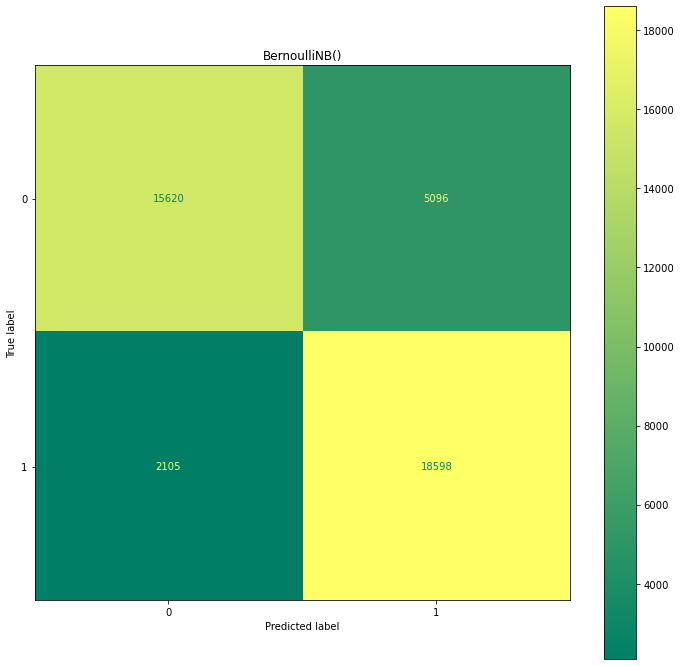

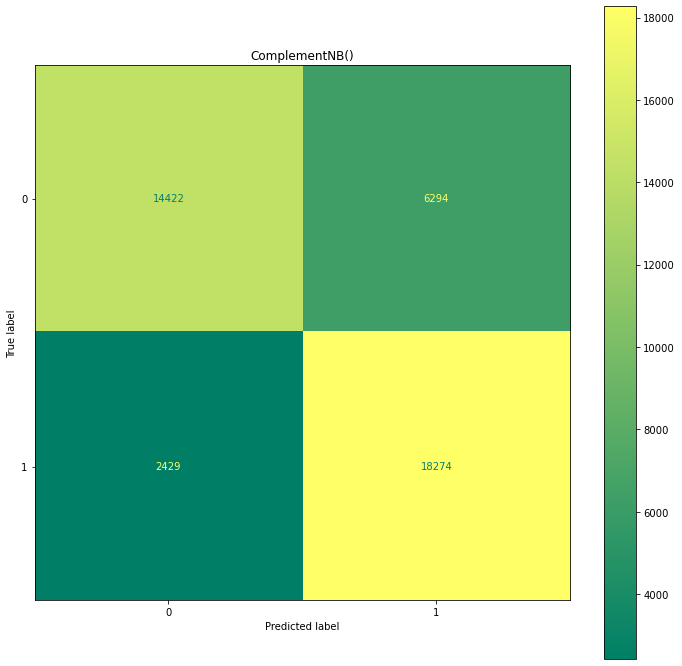

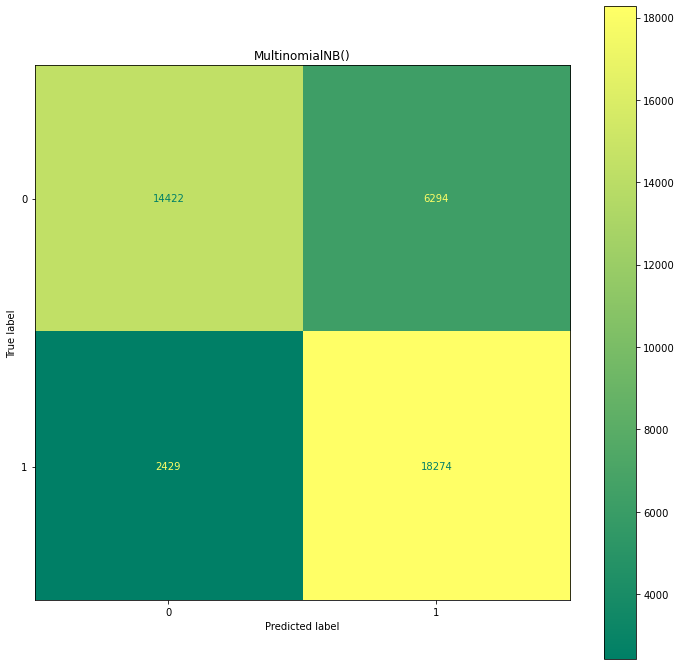

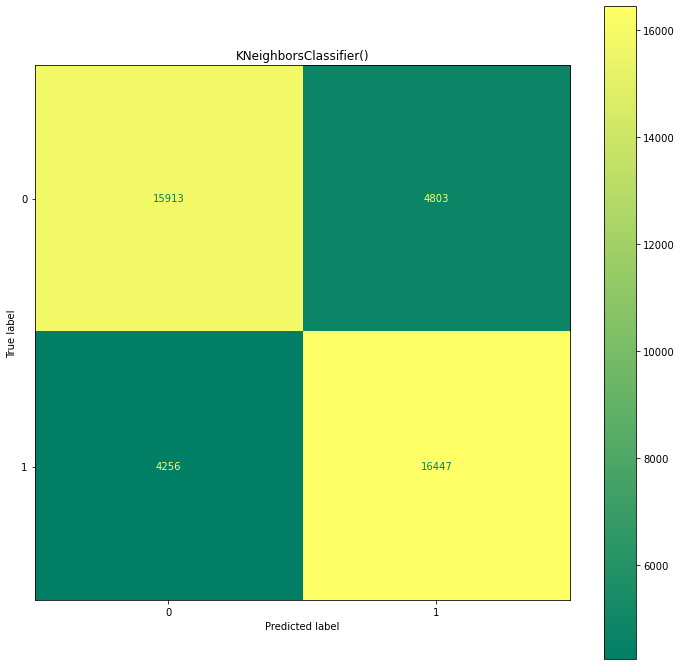

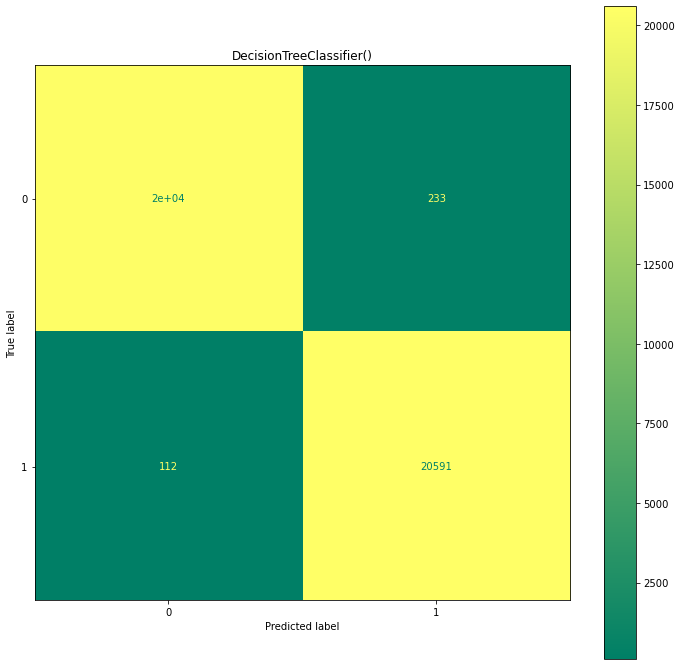

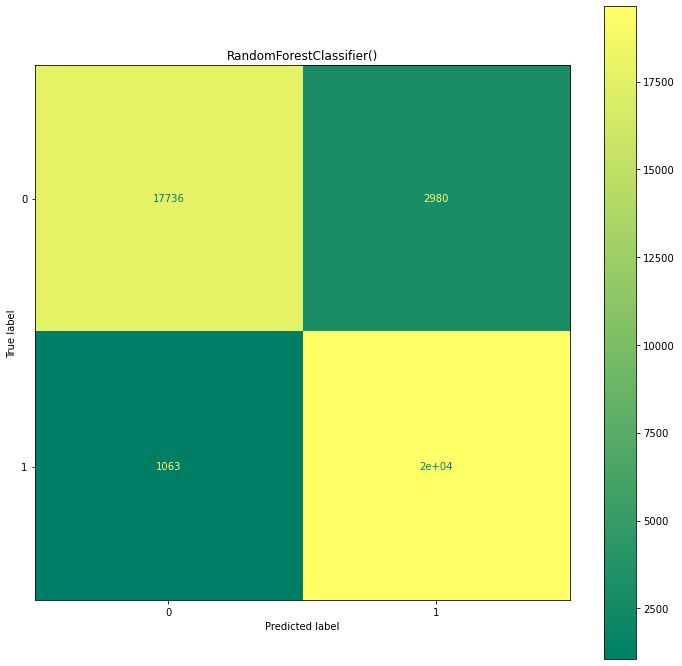

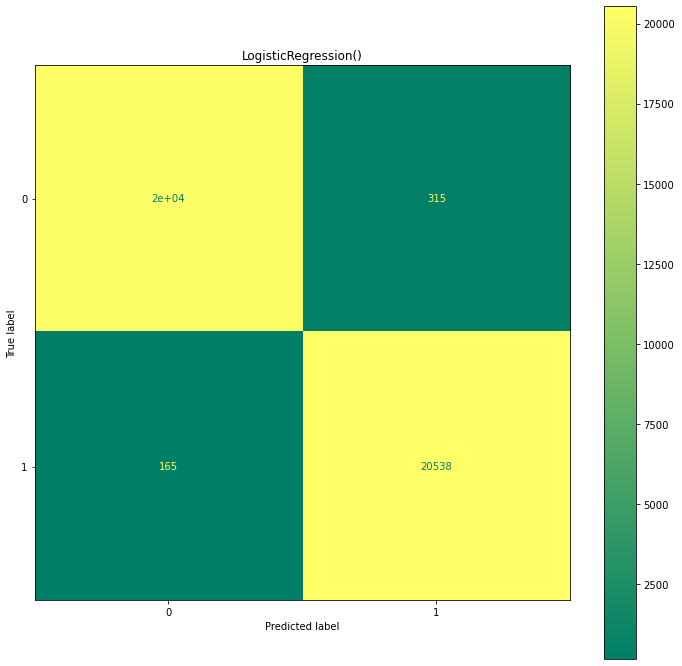

In [176]:
for name, sklearn_classifier in classifiers.items():
     classifier = sklearn_classifier
     classifier.fit(X_train_CV, y_train)
     accuracy = classifier.score(X_train_CV, y_train)
     print(F"Train score: {accuracy:.2%} - {name}")
     
     fig, ax = plt.subplots(figsize =(12,12))
     plot_confusion_matrix(classifier, X_test_CV, y_test, ax=ax, cmap='summer')
     ax.set_title(classifier); 
    
     accuracy = classifier.score(X_test_CV, y_test)
     print(F"Test score: {accuracy:.2%} - {name}")

running through a bunch of simple models to see what the best starting point appears to be before properly evaluating them/tuning their parameters.